In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
import plotly.graph_objs as go
%matplotlib inline
from random import sample
import seaborn as sns
import datetime as dt
from pandas_datareader import data as pdr
from dataclasses import dataclass

In [23]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [24]:
def weekly_data(index):
    index_ffill = index.resample('d').asfreq().ffill() 
    index_fri = index_ffill[index_ffill.index.dayofweek==4]
    return index_fri

In [25]:
def EWMA(df, n):
    EWMA = pd.Series(df["Adj Close"].ewm(span=n).mean(),name = "EWMA_" + str(n))
    return EWMA

def EWMV(df, n):
    EWMV = pd.Series(df.ewm(span=n).mean(),name = "EWMV_" + str(n))
    return EWMV

def ATR(df,n):
    ATR = pd.concat([(df['High']-df['Low']),
           np.abs(df['High'] - df['Adj Close'].shift(1)),
           np.abs(df['Low']-df['Adj Close'].shift(1))],axis=1).max(axis=1).rolling(n).mean()
    return ATR

def DIV(df,N):
    alpha = 1.34
    k =(alpha-1)/(alpha+(N+1)/(N-1))
    c = np.log(df['Adj Close']/df['Open'])
    u = np.log(df['Adj Close']/df['Open'])
    o = np.log(df['Open']/df['Adj Close'].shift(1))
    d = np.log(df['Low']/df['Open'])
    V0 = ((o-o.rolling(N).mean())**2).rolling(N).sum()/(N-1)
    Vc = ((c-c.rolling(N).mean())**2).rolling(N).sum()/(N-1)
    Vrs = (u*(u-c)+d*(d-c)).rolling(N).mean()
    DIV = V0 + k*Vc +(1-k)*Vrs
    return DIV

In [26]:
def g_mean_f1(y_true,y_pred):
    c_m = confusion_matrix(y_true,y_pred)
    p_precision = c_m[0,0] / (c_m[0,0] + c_m[0,1])
    p_recall = c_m[0,0] / (c_m[0,0] + c_m[1,0])
    n_precision = c_m[1,1] / (c_m[1,1] + c_m[1,0])
    n_recall = c_m[1,1] / (c_m[1,1] + c_m[0,1])
    p_f1_score = 2*(p_precision * p_recall)/(p_precision+p_recall)
    n_f1_score = 2*(n_precision * n_recall)/(n_precision+n_recall)
    return (p_f1_score * n_f1_score)**0.5

### US VIX

In [27]:
start = dt.date(2001, 1, 3)
end = dt.date(2022, 11, 29)
vix=pdr.get_data_yahoo('^VIX',start=start,end=end)
vix_w = weekly_data(vix)
vix_w['us_vix_return'] = np.log(vix_w['Adj Close']/vix_w['Adj Close'].shift(1)).fillna(0)
vix_w

,High,Low,Open,Close,Volume,Adj Close,us_vix_return
Date,,,,,,,
2001-01-05,29.040001,27.209999,27.809999,28.670000,0.0,28.670000,0.000000
2001-01-12,25.480000,24.500000,25.309999,24.559999,0.0,24.559999,-0.154732
2001-01-19,24.080000,23.000000,23.620001,23.240000,0.0,23.240000,-0.055244
2001-01-26,23.049999,22.440001,22.520000,22.570000,0.0,22.570000,-0.029253
2001-02-02,21.950001,20.809999,20.870001,21.950001,0.0,21.950001,-0.027854
...,...,...,...,...,...,...,...
2022-10-28,27.590000,25.750000,27.430000,25.750000,0.0,25.750000,-0.142376
2022-11-04,25.709999,24.000000,25.629999,24.549999,0.0,24.549999,-0.047723
2022-11-11,23.910000,22.370001,23.889999,22.520000,0.0,22.520000,-0.086308


In [28]:
vix_w['EWMA_1'] = EWMA(vix_w,1)
vix_w['EWMA_2'] = EWMA(vix_w,2)
vix_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1143 entries, 2001-01-05 to 2022-11-25
Freq: 7D
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   High           1143 non-null   float64
 1   Low            1143 non-null   float64
 2   Open           1143 non-null   float64
 3   Close          1143 non-null   float64
 4   Volume         1143 non-null   float64
 5   Adj Close      1143 non-null   float64
 6   us_vix_return  1143 non-null   float64
 7   EWMA_1         1143 non-null   float64
 8   EWMA_2         1143 non-null   float64
dtypes: float64(9)
memory usage: 89.3 KB


####  USD/JPY

In [29]:
start = dt.date(2001, 1, 3)
end = dt.date(2022, 11, 29)
usd =pdr.get_data_yahoo('JPY=X',start=start,end=end)
usd_w = weekly_data(usd)
usd_w['usd_jpy_return'] = np.log(usd_w['Adj Close']/usd_w['Adj Close'].shift(1)).fillna(0)
usd_w

,High,Low,Open,Close,Volume,Adj Close,usd_jpy_return
Date,,,,,,,
2001-01-05,116.870003,115.940002,116.070000,116.449997,0.0,116.449997,0.000000
2001-01-12,118.559998,117.360001,117.919998,118.470001,0.0,118.470001,0.017198
2001-01-19,118.279999,116.940002,117.820000,117.129997,0.0,117.129997,-0.011375
2001-01-26,117.550003,116.309998,116.639999,117.320000,0.0,117.320000,0.001621
2001-02-02,116.220001,114.900002,115.400002,115.629997,0.0,115.629997,-0.014510
...,...,...,...,...,...,...,...
2022-10-28,147.848007,146.028000,146.274002,146.274002,0.0,146.274002,-0.026326
2022-11-04,148.393005,146.578995,148.393005,148.393005,0.0,148.393005,0.014383
2022-11-11,142.466003,138.888000,141.733994,141.733994,0.0,141.733994,-0.045912


### stock index

In [30]:
start = dt.date(2001, 1, 3)
end = dt.date(2022, 11, 29)
sp500=pdr.get_data_yahoo('^GSPC',start=start,end=end)
sp500_w = weekly_data(sp500)
sp500_w['sp500_return'] = np.log(sp500_w['Adj Close']/sp500_w['Adj Close'].shift(1)).fillna(0)
sp500_w

,High,Low,Open,Close,Volume,Adj Close,sp500_return
Date,,,,,,,
2001-01-05,1334.770020,1294.949951,1333.339966,1298.349976,1.430800e+09,1298.349976,0.000000
2001-01-12,1333.209961,1311.589966,1326.819946,1318.550049,1.276000e+09,1318.550049,0.015438
2001-01-19,1354.550049,1336.739990,1347.969971,1342.540039,1.407800e+09,1342.540039,0.018031
2001-01-26,1357.510010,1342.750000,1357.510010,1354.949951,1.098000e+09,1354.949951,0.009201
2001-02-02,1376.380005,1348.719971,1373.469971,1349.469971,1.048400e+09,1349.469971,-0.004053
...,...,...,...,...,...,...,...
2022-10-28,3905.419922,3808.260010,3808.260010,3901.060059,4.459410e+09,3901.060059,0.038759
2022-11-04,3796.340088,3708.840088,3766.979980,3770.550049,5.400180e+09,3770.550049,-0.034027
2022-11-11,4001.479980,3944.820068,3963.719971,3992.929932,5.593310e+09,3992.929932,0.057304


In [31]:
sp500_w['hsi_return'] = np.log(sp500_w['Adj Close']/sp500_w['Adj Close'].shift(1)).fillna(0)
sp500_w['hsi_volume_return'] = np.log(sp500_w['Volume']/sp500_w['Volume'].shift(1)).fillna(0)
sp500_w['EWMV_2'] = EWMV(sp500_w['hsi_return'],2)
sp500_w['ATR_2'] = ATR(sp500_w,2)
sp500_w['ATR_4'] = ATR(sp500_w,4)
sp500_w['DIV_2'] = DIV(sp500_w,2)
sp500_w['DIV_4'] = DIV(sp500_w,4)
sp500_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1143 entries, 2001-01-05 to 2022-11-25
Freq: 7D
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   High               1143 non-null   float64
 1   Low                1143 non-null   float64
 2   Open               1143 non-null   float64
 3   Close              1143 non-null   float64
 4   Volume             1143 non-null   float64
 5   Adj Close          1143 non-null   float64
 6   sp500_return       1143 non-null   float64
 7   hsi_return         1143 non-null   float64
 8   hsi_volume_return  1143 non-null   float64
 9   EWMV_2             1143 non-null   float64
 10  ATR_2              1142 non-null   float64
 11  ATR_4              1140 non-null   float64
 12  DIV_2              1140 non-null   float64
 13  DIV_4              1136 non-null   float64
dtypes: float64(14)
memory usage: 133.9 KB


###  HK stock index

In [32]:
start = dt.date(2001, 1, 3)
end = dt.date(2022, 11, 29)
hsi=pdr.get_data_yahoo('^HSI',start=start,end=end)
hsi_w = weekly_data(hsi)
hsi_w['hsi_return'] = np.log(hsi_w['Adj Close']/hsi_w['Adj Close'].shift(1)).fillna(0)
hsi_w

,High,Low,Open,Close,Volume,Adj Close,hsi_return
Date,,,,,,,
2001-01-05,15494.559570,15275.900391,15354.160156,15447.610352,0.000000e+00,15447.610352,0.000000
2001-01-12,15330.150391,15157.370117,15157.370117,15295.419922,0.000000e+00,15295.419922,-0.009901
2001-01-19,15964.929688,15682.349609,15682.349609,15933.549805,0.000000e+00,15933.549805,0.040874
2001-01-26,16099.059570,15940.259766,16053.219727,16044.209961,0.000000e+00,16044.209961,0.006921
2001-02-02,16274.669922,16056.200195,16165.429688,16071.290039,0.000000e+00,16071.290039,0.001686
...,...,...,...,...,...,...,...
2022-10-28,15441.990234,14770.089844,15424.940430,14863.059570,3.051258e+09,14863.059570,-0.086819
2022-11-04,16513.160156,15442.759766,15442.759766,16161.139648,3.951121e+09,16161.139648,0.083731
2022-11-11,17368.039062,16829.000000,17120.050781,17325.660156,5.112566e+09,17325.660156,0.069579


### hk vix

In [33]:
hk1 = pd.read_csv('vhsi_pt1.csv',index_col=[0])[::-1]
hk1.index = pd.to_datetime(hk1.index)
hk2 = pd.read_csv('vhsi_pt2.csv',index_col=[0])[::-1]
hk2.index = pd.to_datetime(hk2.index)
hk_vix = pd.concat([hk1,hk2],axis=0)
hk_vix.rename(columns={'Price':'Adj Close'},inplace=True)
hk_vix_w = weekly_data(hk_vix)
hk_vix_w['hk_vix_return'] = np.log(hk_vix_w['Adj Close']/hk_vix_w['Adj Close'].shift(1)).fillna(0)
hk_vix_w

,Adj Close,Open,High,Low,Vol.,Change %,hk_vix_return
Date,,,,,,,
2001-01-05,27.27,27.27,27.27,27.27,NaN,-4.48%,0.000000
2001-01-12,27.09,27.09,27.09,27.09,NaN,-3.70%,-0.006623
2001-01-19,23.11,23.11,23.11,23.11,NaN,-8.04%,-0.158899
2001-01-26,24.52,24.52,24.52,24.52,NaN,5.60%,0.059224
2001-02-02,25.93,25.93,25.93,25.93,NaN,-4.84%,0.055911
...,...,...,...,...,...,...,...
2022-10-28,39.70,35.75,40.99,34.90,NaN,8.53%,0.123150
2022-11-04,37.74,35.97,39.28,35.91,NaN,1.86%,-0.050631
2022-11-11,37.32,33.91,38.17,33.75,NaN,3.90%,-0.011191


### bond yield

In [34]:
start = dt.date(2001, 1, 3)
end = dt.date(2022, 11, 29)
bond =pdr.get_data_yahoo('^FVX',start=start,end=end)
bond_w = weekly_data(bond)
bond_w['usd_jpy_return'] = np.log(bond_w['Adj Close']/bond_w['Adj Close'].shift(1)).fillna(0)
bond_w

,High,Low,Open,Close,Volume,Adj Close,usd_jpy_return
Date,,,,,,,
2001-01-05,4.828,4.665,4.750,4.672,0.0,4.672,0.000000
2001-01-12,4.961,4.839,4.839,4.947,0.0,4.947,0.057194
2001-01-19,4.839,4.700,4.771,4.825,0.0,4.825,-0.024971
2001-01-26,4.919,4.854,4.854,4.890,0.0,4.890,0.013382
2001-02-02,4.844,4.735,4.735,4.829,0.0,4.829,-0.012553
...,...,...,...,...,...,...,...
2022-10-28,4.213,4.116,4.146,4.190,0.0,4.190,-0.038394
2022-11-04,4.452,4.295,4.391,4.326,0.0,4.326,0.031943
2022-11-11,3.938,3.938,3.938,3.938,0.0,3.938,-0.093970


### Variables

In [35]:
Y = np.sign(np.log(vix_w['Adj Close']/vix_w['Adj Close'].shift(1))).shift(-1)
Y = Y.apply(lambda x:np.where(x==0,-1,x))
Y.name = 'vix'

data =pd.concat([Y,
                 vix_w[['Adj Close','High','Low','us_vix_return']],
                 sp500_w[['hsi_return','EWMV_2','ATR_2','ATR_4','DIV_2','DIV_4']],
                usd_w['usd_jpy_return'],
                hk_vix_w[['hk_vix_return']],
                hsi_w['hsi_return'],
                bond_w['usd_jpy_return'],
                ],axis=1,join='inner')
data

,vix,Adj Close,High,Low,us_vix_return,hsi_return,EWMV_2,ATR_2,ATR_4,DIV_2,DIV_4,usd_jpy_return,hk_vix_return,hsi_return,usd_jpy_return
Date,,,,,,,,,,,,,,,
2001-01-05,-1.0,28.670000,29.040001,27.209999,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000
2001-01-12,-1.0,24.559999,25.480000,24.500000,-0.154732,0.015438,0.011579,37.340027,NaN,NaN,NaN,0.017198,-0.006623,-0.009901,0.057194
2001-01-19,-1.0,23.240000,24.080000,23.000000,-0.055244,0.018031,0.016046,35.429993,NaN,NaN,NaN,-0.011375,-0.158899,0.040874,-0.024971
2001-01-26,-1.0,22.570000,23.049999,22.440001,-0.029253,0.009201,0.011426,25.484985,31.412506,0.000093,NaN,0.001621,0.059224,0.006921,0.013382
2001-02-02,1.0,21.950001,21.950001,20.809999,-0.027854,-0.004053,0.001064,21.315002,28.372498,0.000087,NaN,-0.014510,0.055911,0.001686,-0.012553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-28,-1.0,25.750000,27.590000,25.750000,-0.142376,0.038759,0.034918,163.744873,145.232422,0.000114,0.001083,-0.026326,0.123150,-0.086819,-0.038394
2022-11-04,-1.0,24.549999,25.709999,24.000000,-0.047723,-0.034027,-0.011046,172.444946,163.007446,0.000754,0.000760,0.014383,-0.050631,0.083731,0.031943
2022-11-11,1.0,22.520000,23.910000,22.370001,-0.086308,0.057304,0.034521,211.574951,187.659912,0.002576,0.001147,-0.045912,-0.011191,0.069579,-0.093970


In [36]:
Y = data.iloc[:,0]
X = data.iloc[:,1:].ffill().bfill()

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1143 entries, 2001-01-05 to 2022-11-25
Freq: 7D
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Adj Close       1143 non-null   float64
 1   High            1143 non-null   float64
 2   Low             1143 non-null   float64
 3   us_vix_return   1143 non-null   float64
 4   hsi_return      1143 non-null   float64
 5   EWMV_2          1143 non-null   float64
 6   ATR_2           1143 non-null   float64
 7   ATR_4           1143 non-null   float64
 8   DIV_2           1143 non-null   float64
 9   DIV_4           1143 non-null   float64
 10  usd_jpy_return  1143 non-null   float64
 11  hk_vix_return   1143 non-null   float64
 12  hsi_return      1143 non-null   float64
 13  usd_jpy_return  1143 non-null   float64
dtypes: float64(14)
memory usage: 166.2 KB


<AxesSubplot: >

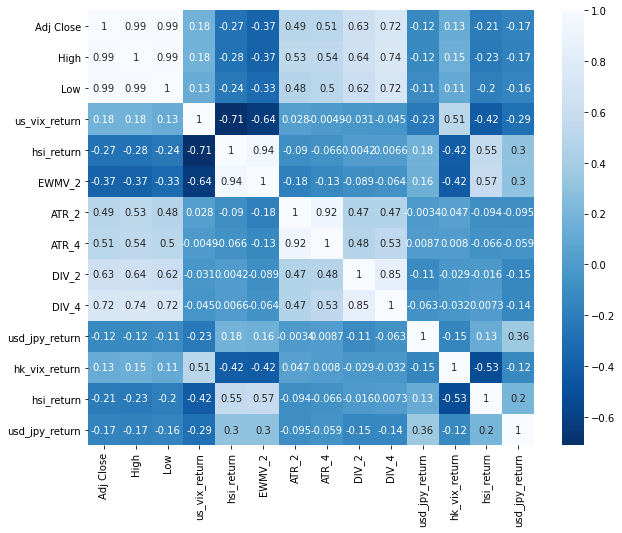

In [38]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(),annot=True,cmap='Blues_r')

In [39]:
scaler = StandardScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(X),index = X.index,columns=X.columns)
scaled_X

,Adj Close,High,Low,us_vix_return,hsi_return,EWMV_2,ATR_2,ATR_4,DIV_2,DIV_4,usd_jpy_return,hk_vix_return,hsi_return,usd_jpy_return
Date,,,,,,,,,,,,,,
2001-01-05,1.002611,0.845123,0.978901,0.002075,-0.039507,-0.056521,-0.122633,-0.288424,-0.308726,0.092710,-0.011314,-0.000670,-0.003828,0.002315
2001-01-12,0.536243,0.473329,0.652884,-1.091786,0.576507,0.606932,-0.122633,-0.288424,-0.308726,0.092710,1.265744,-0.061043,-0.339828,0.805875
2001-01-19,0.386460,0.327118,0.472432,-0.388467,0.679939,0.862866,-0.169399,-0.288424,-0.308726,0.092710,-0.856015,-1.449229,1.383266,-0.348515
2001-01-26,0.310434,0.219548,0.405063,-0.204728,0.327630,0.598149,-0.412899,-0.288424,-0.308726,0.092710,0.109044,0.539226,0.231048,0.190322
2001-02-02,0.240082,0.104669,0.208972,-0.194839,-0.201211,0.004453,-0.514999,-0.369135,-0.312187,0.092710,-1.088771,0.509031,0.053402,-0.174049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-28,0.671274,0.693690,0.803261,-1.004433,1.507040,1.944213,2.972342,2.733450,-0.295876,0.380504,-1.966228,1.121992,-2.950126,-0.537113
2022-11-04,0.535108,0.497349,0.592733,-0.335296,-1.397242,-0.689428,3.185360,3.205370,0.088052,0.132950,1.056696,-0.462230,2.837679,0.451100
2022-11-11,0.304761,0.309364,0.396642,-0.608069,2.247007,1.921487,4.143444,3.859883,1.182148,0.429681,-3.420617,-0.102691,2.357427,-1.317942


### Train validation test

In [40]:
# train and test
split_date_1 = dt.datetime(2018,6,29)
split_date_2 = dt.datetime(2018,7,6)
X_train, X_test = scaled_X.loc[:split_date_1,:], scaled_X.loc[split_date_2:,:]
Y_train, Y_test = Y[:split_date_1], Y[split_date_2:]
# train and validation
split_date_1 = dt.datetime(2014,4,4)
split_date_2 = dt.datetime(2014,4,11)
X_train_v, X_validation = X_train.loc[:split_date_1,:], X_train.loc[split_date_2:,:]
Y_train_v, Y_validation = Y_train.loc[:split_date_1], Y_train.loc[split_date_2:]

In [41]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [42]:
names = []
is_accuracy = []
os_accuracy = []
is_gmeanf1 = []
os_gmeanf1 = []

### Decision Tree

In [43]:
from sklearn.tree import DecisionTreeClassifier 

In [63]:
# my_cv = TimeSeriesSplit(n_splits=2).split(X_train_v)
# cv_params = { 'min_samples_split': [2, 3, 4], 'max_depth': np.arange(3,15),
#                  'min_samples_leaf': [1,2,3,4]}
# model = DecisionTreeClassifier()
# optimized_DT = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=my_cv)
# optimized_DT.fit(np.array(X_train_v), np.array(Y_train_v))
# model = optimized_DT.best_estimator_
# print('Best parameters：{0}'.format(optimized_DT.best_params_))
# print('Score:{0}'.format(optimized_DT.best_score_))

Best parameters：{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Score:0.5521739130434783


In [44]:
DT = DecisionTreeClassifier(max_depth=3,min_samples_leaf=1,min_samples_split=2).fit(X_train_v, Y_train_v)

In [45]:
y_pred_DT_is = DT.predict(X_train_v)
y_pred_DT_os = DT.predict(X_validation)
accuracy_DT_is = metrics.accuracy_score(Y_train_v, y_pred_DT_is)
accuracy_DT_os = metrics.accuracy_score(Y_validation, y_pred_DT_os)
print("DT accuarcy in sample:",accuracy_DT_is)
print("DT accuarcy out sample:",accuracy_DT_os)

DT accuarcy in sample: 0.6026011560693642
DT accuarcy out sample: 0.5565610859728507


In [46]:
g_mean_f1_DT_is = g_mean_f1(Y_train_v, y_pred_DT_is)
g_mean_f1_DT_os = g_mean_f1(Y_validation, y_pred_DT_os)
print("DT gmean f1 in sample:",g_mean_f1_DT_is)
print("DT gmean f1 out sample:",g_mean_f1_DT_os)

DT gmean f1 in sample: 0.6001471883464822
DT gmean f1 out sample: 0.5470846639516539


In [47]:
names.append('DT')
is_accuracy.append(accuracy_DT_is)
os_accuracy.append(accuracy_DT_os)
is_gmeanf1.append(g_mean_f1_DT_is)
os_gmeanf1.append(g_mean_f1_DT_os)

### Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [69]:
# my_cv = TimeSeriesSplit(n_splits=2).split(X_train_v)
# cv_params = { 'n_estimators':[25,50,100,200],'min_samples_split': [2, 3, 4], 'max_depth': np.arange(3,13),
#                  'min_samples_leaf': [1,2,3],'max_features':["auto", "sqrt", "log2"]}
# model = RandomForestClassifier()
# optimized_RF = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=my_cv)
# optimized_RF.fit(np.array(X_train_v), np.array(Y_train_v))
# print('Best parameters：{0}'.format(optimized_RF.best_params_))
# print('Score:{0}'.format(optimized_RF.best_score_))

Best parameters：{'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 50}
Score:0.5847826086956522


In [49]:
RF= RandomForestClassifier(n_estimators=50,  max_features="sqrt", max_depth=4,
                           min_samples_leaf=1, min_samples_split=3).fit(X_train_v,Y_train_v)

In [50]:
y_pred_RF_is = RF.predict(X_train_v)
y_pred_RF_os = RF.predict(X_validation)
accuracy_RF_is = metrics.accuracy_score(Y_train_v, y_pred_RF_is)
accuracy_RF_os = metrics.accuracy_score(Y_validation, y_pred_RF_os)
print("RF accuarcy in sample:",accuracy_RF_is)
print("RF accuarcy out sample:",accuracy_RF_os)

RF accuarcy in sample: 0.7095375722543352
RF accuarcy out sample: 0.5610859728506787


In [51]:
g_mean_f1_RF_is = g_mean_f1(Y_train_v, y_pred_RF_is)
g_mean_f1_RF_os = g_mean_f1(Y_validation, y_pred_RF_os)
print("RF gmean f1 in sample:",g_mean_f1_RF_is)
print("RF gmean f1 out sample:",g_mean_f1_RF_os)

RF gmean f1 in sample: 0.700235629937109
RF gmean f1 out sample: 0.5549410336608953


In [52]:
names.append('RF')
is_accuracy.append(accuracy_RF_is)
os_accuracy.append(accuracy_RF_os)
is_gmeanf1.append(g_mean_f1_RF_is)
os_gmeanf1.append(g_mean_f1_RF_os)

### Extremely Randomized Trees

In [53]:
from sklearn.ensemble import ExtraTreesClassifier

In [75]:
# my_cv = TimeSeriesSplit(n_splits=2).split(X_train_v)
# cv_params = {'n_estimators':[25,50,100,200],'min_samples_split': [2, 3, 4], 'max_depth': np.arange(3,13),
#                  'min_samples_leaf': [1,2,3],'max_features':["auto", "sqrt", "log2"]}
# model = ExtraTreesClassifier()
# optimized_ETC = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=my_cv)
# optimized_ETC.fit(np.array(X_train_v), np.array(Y_train_v))
# print('Best parameters：{0}'.format(optimized_ETC.best_params_))
# print('Score:{0}'.format(optimized_ETC.best_score_))

Best parameters：{'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}
Score:0.5956521739130435


In [54]:
ETC= ExtraTreesClassifier(n_estimators=25, 
                          max_depth=4,
                          max_features='log2',
                          min_samples_leaf=1,
                          min_samples_split=2).fit(X_train_v,Y_train_v.values.ravel())

In [55]:
y_pred_ETC_is = ETC.predict(X_train_v)
y_pred_ETC_os = ETC.predict(X_validation)
accuracy_ETC_is = metrics.accuracy_score(Y_train_v, y_pred_ETC_is)
accuracy_ETC_os = metrics.accuracy_score(Y_validation, y_pred_ETC_os)
print("ETC accuarcy in sample:",accuracy_ETC_is)
print("ETC accuarcy out sample:",accuracy_ETC_os)

ETC accuarcy in sample: 0.6184971098265896
ETC accuarcy out sample: 0.6108597285067874


In [56]:
g_mean_f1_ETC_is = g_mean_f1(Y_train_v, y_pred_ETC_is)
g_mean_f1_ETC_os = g_mean_f1(Y_validation, y_pred_ETC_os)
print("ETC gmean f1 in sample:",g_mean_f1_ETC_is)
print("ETC gmean f1 out sample:",g_mean_f1_ETC_os)

ETC gmean f1 in sample: 0.5999584368802916
ETC gmean f1 out sample: 0.6107651561899445


In [57]:
names.append('ETC')
is_accuracy.append(accuracy_ETC_is)
os_accuracy.append(accuracy_ETC_os)
is_gmeanf1.append(g_mean_f1_ETC_is)
os_gmeanf1.append(g_mean_f1_ETC_os)

### AdaBoost

In [58]:
from sklearn.ensemble import AdaBoostClassifier

In [111]:
# my_cv = TimeSeriesSplit(n_splits=2).split(X_train_v)
# cv_params = {'n_estimators':[25,50,100,200],'learning_rate': np.linspace(0.1,1,10),'algorithm':['SAMME','SAMME.R'],
#             'base_estimator__min_samples_split': [2, 3, 4], 'base_estimator__max_depth': np.arange(1,5),
#                  'base_estimator__min_samples_leaf': [1,2,3]}
# base_estimator=DecisionTreeClassifier()
# model = AdaBoostClassifier(base_estimator=base_estimator)
# optimized_ADB = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=my_cv)
# optimized_ADB.fit(np.array(X_train_v), np.array(Y_train_v))
# print('Best parameters：{0}'.format(optimized_ADB.best_params_))
# print('Score:{0}'.format(optimized_ADB.best_score_))

Best parameters：{'algorithm': 'SAMME', 'base_estimator__max_depth': 3, 'base_estimator__min_samples_leaf': 3, 'base_estimator__min_samples_split': 3, 'learning_rate': 0.4, 'n_estimators': 25}
Score:0.5826086956521739


In [59]:
base_estimator=DecisionTreeClassifier(max_depth=3,min_samples_leaf=3,min_samples_split=3)
ADB = AdaBoostClassifier(n_estimators=25, algorithm= 'SAMME',learning_rate=0.4,base_estimator=base_estimator).fit(X_train_v,Y_train_v)

In [60]:
y_pred_ADB_is = ADB.predict(X_train_v)
y_pred_ADB_os = ADB.predict(X_validation)
accuracy_ADB_is = metrics.accuracy_score(Y_train_v, y_pred_ADB_is)
accuracy_ADB_os = metrics.accuracy_score(Y_validation, y_pred_ADB_os)
print("ADB accuarcy in sample:",accuracy_ADB_is)
print("ADB accuarcy out sample:",accuracy_ADB_os)

ADB accuarcy in sample: 0.6430635838150289
ADB accuarcy out sample: 0.5701357466063348


In [61]:
g_mean_f1_ADB_is = g_mean_f1(Y_train_v, y_pred_ADB_is)
g_mean_f1_ADB_os = g_mean_f1(Y_validation, y_pred_ADB_os)
print("ADB gmean f1 in sample:",g_mean_f1_ADB_is)
print("ADB gmean f1 out sample:",g_mean_f1_ADB_os)

ADB gmean f1 in sample: 0.6185086477217837
ADB gmean f1 out sample: 0.56616908868363


In [62]:
names.append('ADB')
is_accuracy.append(accuracy_ADB_is)
os_accuracy.append(accuracy_ADB_os)
is_gmeanf1.append(g_mean_f1_ADB_is)
os_gmeanf1.append(g_mean_f1_ADB_os)

### XGBoost

In [63]:
from xgboost import XGBClassifier
Y_xgbc_train_v = Y_train_v.apply(lambda x:np.where(x==-1,0,x))
Y_xgbc_validation = Y_validation.apply(lambda x:np.where(x==-1,0,x))

In [117]:
# my_cv = TimeSeriesSplit(n_splits=2).split(X_train_v)
# cv_params = {'n_estimators': [25,50,100,200], 'learning_rate': [0.01, 0.1, 0.5, 1], 'max_depth': np.arange(3,13),
#                  'min_child_weight': [4, 5, 6], 'gamma': [1, 3], 'reg_alpha': [0.1, 0.3,0.5],"reg_lambda": [0.3,0.5,0.7,0.9]}
# other_params = {'learning_rate': 0.1, 'n_estimators': 90, 'max_depth': 7, 'min_child_weight': 4,
#                      'gamma': 1, 'reg_alpha': 0.1, "reg_lambda": 0.9}
# model = XGBClassifier()
# optimized_XGBC = GridSearchCV(estimator=model, param_grid=cv_params, scoring='accuracy', cv=my_cv)
# optimized_XGBC.fit(np.array(X_train_v), np.array(Y_xgbc_train_v))
# print('Best parameters：{0}'.format(optimized_XGBC.best_params_))
# print('Score:{0}'.format(optimized_XGBC.best_score_))

Best parameters：{'gamma': 1, 'learning_rate': 0.5, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 25, 'reg_alpha': 0.5, 'reg_lambda': 0.7}
Score:0.5760869565217391


In [64]:
XGBC = XGBClassifier(learning_rate= 0.5,
                     n_estimators=25,
                     max_depth= 3, 
                     min_child_weight=4, 
                     gamma=1, 
                     reg_alpha= 0.5,
                     reg_lambda=0.7).fit(np.array(X_train_v), np.array(Y_xgbc_train_v))

In [65]:
y_pred_XGBC_is = XGBC.predict(X_train_v)
y_pred_XGBC_is = np.where(y_pred_XGBC_is==0,-1,y_pred_XGBC_is)
y_pred_XGBC_os = XGBC.predict(X_validation)
y_pred_XGBC_os = np.where(y_pred_XGBC_os==0,-1,y_pred_XGBC_os)
accuracy_XGBC_is = metrics.accuracy_score(Y_train_v, y_pred_XGBC_is)
accuracy_XGBC_os = metrics.accuracy_score(Y_validation, y_pred_XGBC_os)
print("XGBC accuarcy in sample:",accuracy_XGBC_is)
print("XGBC accuarcy out sample:",accuracy_XGBC_os)

XGBC accuarcy in sample: 0.8829479768786127
XGBC accuarcy out sample: 0.5565610859728507


In [66]:
g_mean_f1_XGBC_is = g_mean_f1(Y_train_v, y_pred_XGBC_is)
g_mean_f1_XGBC_os = g_mean_f1(Y_validation, y_pred_XGBC_os)
print("XGBC gmean f1 in sample:",g_mean_f1_XGBC_is)
print("XGBC gmean f1 out sample:",g_mean_f1_XGBC_os)

XGBC gmean f1 in sample: 0.8826969631340771
XGBC gmean f1 out sample: 0.5439728235385827


In [67]:
names.append('XGBC')
is_accuracy.append(accuracy_XGBC_is)
os_accuracy.append(accuracy_XGBC_os)
is_gmeanf1.append(g_mean_f1_XGBC_is)
os_gmeanf1.append(g_mean_f1_XGBC_os)

### Model Comparison

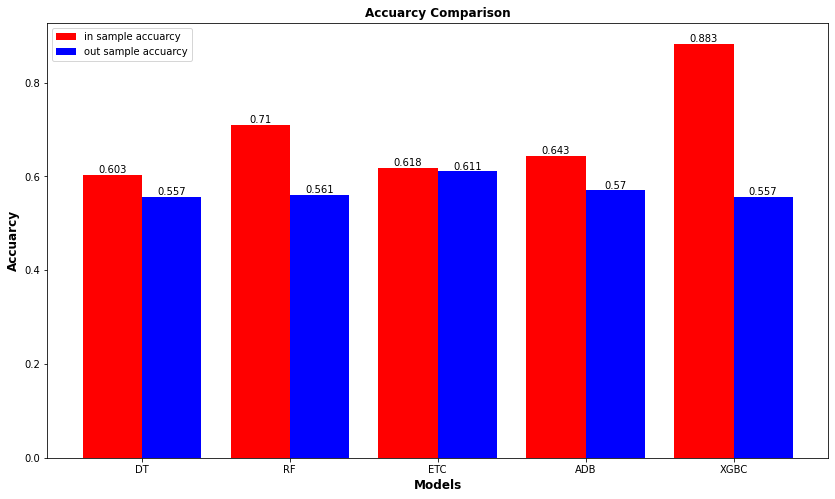

In [68]:
plt.figure(figsize = (14,8))

accuracy_df =pd.DataFrame({'name':names,'accuracy_is':is_accuracy,'accuracy_os':os_accuracy}).set_index('name')
x_axis = np.arange(len(accuracy_df))

barplot_is_accuarcy = plt.bar(x_axis-0.2, accuracy_df['accuracy_is'], 0.4, label='in sample accuarcy',color='red')
barplot_os_accuarcy = plt.bar(x_axis+0.2, accuracy_df['accuracy_os'], 0.4, label='out sample accuarcy',color='blue')

plt.bar_label(barplot_is_accuarcy, labels = np.round(accuracy_df['accuracy_is'],3))
plt.bar_label(barplot_os_accuarcy, labels = np.round(accuracy_df['accuracy_os'],3))

plt.xticks(x_axis, accuracy_df.index)
plt.xlabel("Models", fontsize = 12, fontweight = "bold") 
plt.ylabel("Accuarcy",fontsize = 12, fontweight = "bold")
plt.title("Accuarcy Comparison", fontsize = 12, fontweight = "bold")
plt.legend()
plt.show()

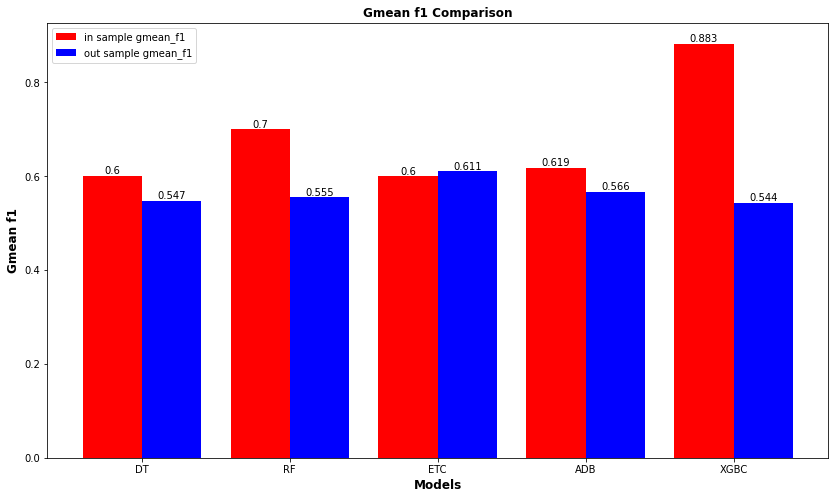

In [69]:
plt.figure(figsize = (14,8))

f1_df =pd.DataFrame({'name':names,'f1_is':is_gmeanf1,'f1_os':os_gmeanf1}).set_index('name')
x_axis = np.arange(len(f1_df))

barplot_is_f1 = plt.bar(x_axis-0.2, f1_df['f1_is'], 0.4, label='in sample gmean_f1',color='red')
barplot_os_f1 = plt.bar(x_axis+0.2, f1_df['f1_os'], 0.4, label='out sample gmean_f1',color='blue')

plt.bar_label(barplot_is_f1, labels = np.round(f1_df['f1_is'],3))
plt.bar_label(barplot_os_f1, labels = np.round(f1_df['f1_os'],3))

plt.xticks(x_axis, f1_df.index)
plt.xlabel("Models", fontsize = 12, fontweight = "bold") 
plt.ylabel("Gmean f1",fontsize = 12, fontweight = "bold")
plt.title("Gmean f1 Comparison", fontsize = 12, fontweight = "bold")
plt.legend()
plt.show()

### Select Random Forest model

In [110]:
RF= RandomForestClassifier(n_estimators=50,  max_features="sqrt", max_depth=4,
                           min_samples_leaf=1, min_samples_split=3).fit(X_train_v,Y_train_v)

In [111]:
y_pred_RF_is = RF.predict(X_train)
y_pred_RF_os = RF.predict(X_test)
accuracy_RF_is = metrics.accuracy_score(Y_train, y_pred_RF_is)
accuracy_RF_os = metrics.accuracy_score(Y_test.dropna(), y_pred_RF_os[:-1])
print("RF accuarcy in sample:",accuracy_RF_is)
print("RF accuarcy out sample:",accuracy_RF_os)

RF accuarcy in sample: 0.6736035049288062
RF accuarcy out sample: 0.5676855895196506


In [112]:
g_mean_f1_RF_is = g_mean_f1(Y_train, y_pred_RF_is)
g_mean_f1_RF_os = g_mean_f1(Y_test.dropna(), y_pred_RF_os[:-1])
print("RF gmean f1 in sample:",g_mean_f1_RF_is)
print("RF gmean f1 out sample:",g_mean_f1_RF_os)

RF gmean f1 in sample: 0.6670347033228753
RF gmean f1 out sample: 0.5420059887153266


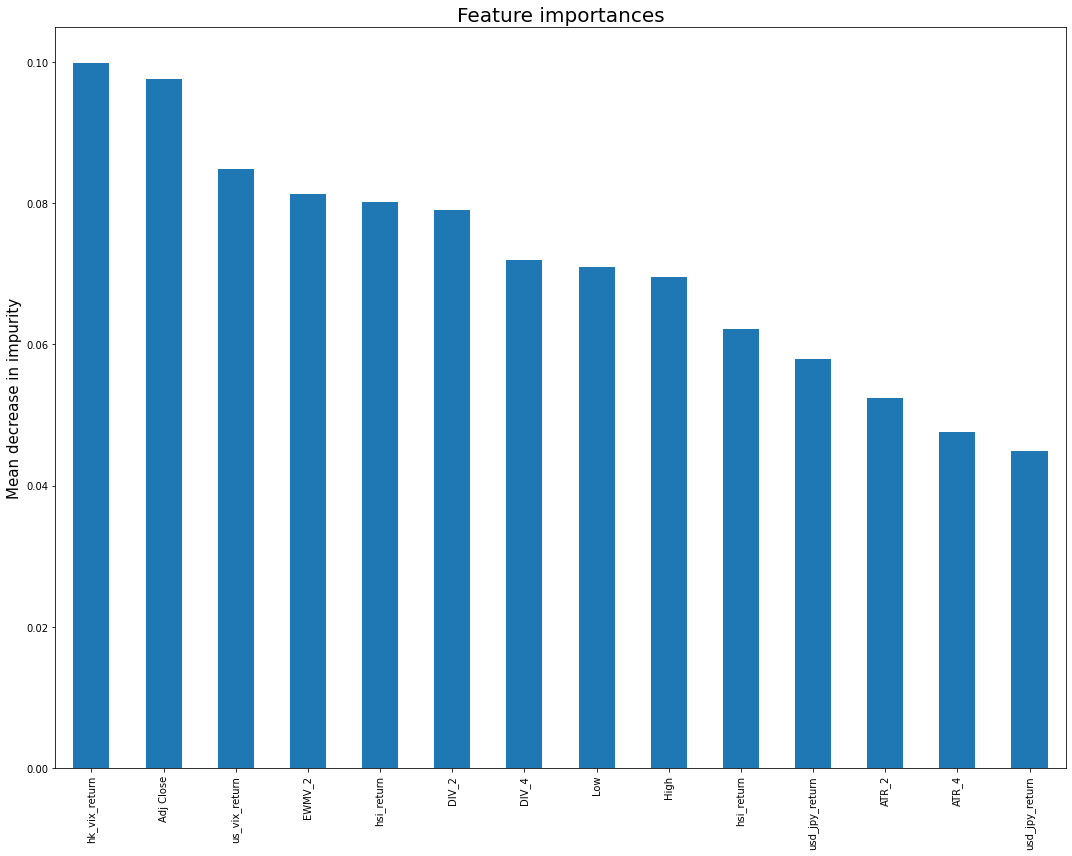

In [119]:
forest_importances = pd.Series(RF.feature_importances_,index=X_train.columns)
forest_importances.sort_values(ascending=False,inplace=True)

fig,ax=plt.subplots(figsize=(15,12))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances",fontsize=20) 
ax.set_ylabel("Mean decrease in impurity",fontsize=15)
fig.tight_layout()

### predict result

In [113]:
result = pd.DataFrame({'actual':Y_test,'pred':RF.predict(X_test)})
result

,actual,pred
Date,,
2018-07-06,-1.0,1.0
2018-07-13,1.0,1.0
2018-07-20,1.0,1.0
2018-07-27,-1.0,1.0
2018-08-03,1.0,1.0
...,...,...
2022-10-28,-1.0,-1.0
2022-11-04,-1.0,-1.0
2022-11-11,1.0,-1.0


In [114]:
result.to_csv('us_result.csv')

In [118]:
### class 1
len(result[result.actual == 1])/ len(result)

0.43043478260869567

In [117]:
### class 0
len(result[result.actual == -1]) / len(result)

0.5652173913043478